In [1]:
import sys
sys.path.insert(0, ".")

import logging
import os
import cv2
from collections import OrderedDict, defaultdict

from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
import torch
from fvcore.common.checkpoint import Checkpointer, PeriodicCheckpointer
from torch.cuda import amp
from torch.nn import SyncBatchNorm
from torch.nn.parallel import DistributedDataParallel
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

import detectron2.utils.comm as d2_comm
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import DatasetEvaluators, inference_on_dataset
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import CommonMetricPrinter, get_event_storage

import tridet.modeling  # pylint: disable=unused-import
import tridet.utils.comm as comm
from tridet.data import build_test_dataloader, build_train_dataloader
from tridet.data.dataset_mappers import get_dataset_mapper
from tridet.data.datasets import random_sample_dataset_dicts, register_datasets
from tridet.evaluators import get_evaluator
from tridet.modeling import build_tta_model
from tridet.utils.s3 import sync_output_dir_s3
from tridet.utils.setup import setup
from tridet.utils.train import get_inference_output_dir, print_test_results
from tridet.utils.visualization import mosaic, save_vis
from tridet.utils.wandb import flatten_dict, log_nested_dict
from tridet.visualizers import get_dataloader_visualizer, get_predictions_visualizer

LOG = logging.getLogger('tridet')

In [2]:
def regen_config(cfg_path, cfg_name, exp_name):
    GlobalHydra.instance().clear()
    initialize(config_path=cfg_path)
    cfg = compose(config_name=cfg_name, 
                  overrides=["+experiments={}".format(exp_name),
                            "SOLVER.IMS_PER_BATCH=1"])
    #print(OmegaConf.to_yaml(cfg))
    return cfg
    
def dataloader_vis(cfg_path, cfg_name, exp_name):
    cfg = regen_config(cfg_path, cfg_name, exp_name)
    setup(cfg)
    dataset_names = register_datasets(cfg)
    dataset_name = cfg.DATASETS.TEST.NAME
    mapper = get_dataset_mapper(cfg, is_train=False)
    dataloader, _ = build_test_dataloader(cfg, dataset_name, mapper=mapper)

    visualizer_names = MetadataCatalog.get(cfg.DATASETS.TRAIN.NAME).loader_visualizers
    for batch_idx, batch in tqdm(enumerate(dataloader)):
        viz_images = defaultdict(dict)
        for viz_name in visualizer_names:
            viz = get_dataloader_visualizer(cfg, viz_name, cfg.DATASETS.TRAIN.NAME)
            for idx, x in enumerate(batch):
                viz_images[idx].update(viz.visualize(x))

        for k in range(len(batch)):
            print(batch[0]['extrinsics'])
            gt_viz = mosaic(list(viz_images[k].values()))
            fig = plt.figure(figsize=(16,16))
            plt.imshow(cv2.cvtColor(gt_viz[:, :, ::-1], cv2.COLOR_BGR2RGB))
            plt.show()
            break
        # Only visualize one batch
        break
        
def do_test_vis(cfg_path, cfg_name, exp_name):
    cfg = regen_config(cfg_path, cfg_name, exp_name)
    setup(cfg)
    dataset_names = register_datasets(cfg)
    dataset_name = cfg.DATASETS.TEST.NAME
    mapper = get_dataset_mapper(cfg, is_train=False)
    dataloader, _ = build_test_dataloader(cfg, dataset_name, mapper=mapper)
    # Build and load model
    model = build_model(cfg)
    checkpoint_file = cfg.MODEL.CKPT
    if checkpoint_file:
        Checkpointer(model).load(checkpoint_file)
    # Test logic
    pred_visualizer_names = MetadataCatalog.get(dataset_name).pred_visualizers
    gt_visualizer_names = MetadataCatalog.get(cfg.DATASETS.TRAIN.NAME).loader_visualizers
    dset_output_dir = get_inference_output_dir(dataset_name, is_last=True, use_tta=False)
    evaluator_names = MetadataCatalog.get(dataset_name).evaluators
    evaluators = []
    for evaluator_name in evaluator_names:
        evaluator = get_evaluator(cfg, dataset_name, evaluator_name, dset_output_dir)
        evaluators.append(evaluator)
    evaluator = DatasetEvaluators(evaluators)
    per_dataset_results = inference_on_dataset(model, dataloader, evaluator)
    sampled_dataset_dicts, inds = random_sample_dataset_dicts(
        dataset_name, 
        num_samples=cfg.VIS.PREDICTIONS_MAX_NUM_SAMPLES
    )
    viz_images = defaultdict(dict)
    for viz_name in pred_visualizer_names:
        LOG.info(f"Running prediction visualizer: {viz_name}")
        visualizer = get_predictions_visualizer(cfg, viz_name, dataset_name, dset_output_dir)
        for x in sampled_dataset_dicts:
            sample_id = x['sample_id']
            print("intrinsics", x['intrinsics'])
            print("intrinsics", type(x['intrinsics']))
            print("extrinsics", x['extrinsics'])
            viz_images[sample_id].update(visualizer.visualize(x))            
            plt_viz = mosaic(list(viz_images[sample_id].values()))
            fig = plt.figure(figsize=(16,16))
            plt.imshow(cv2.cvtColor(plt_viz[:, :, ::-1], cv2.COLOR_BGR2RGB))
            plt.show()
            break

/home/ubuntu/miniconda3/envs/dd3d/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'visualize_dataloader': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.626 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


100%|██████████| 16/16 [00:02<00:00,  7.86it/s]
0it [00:00, ?it/s]

wxyz: +0.508 -0.497i +0.498j -0.496k, tvec: ([1.72 0.00 1.49])


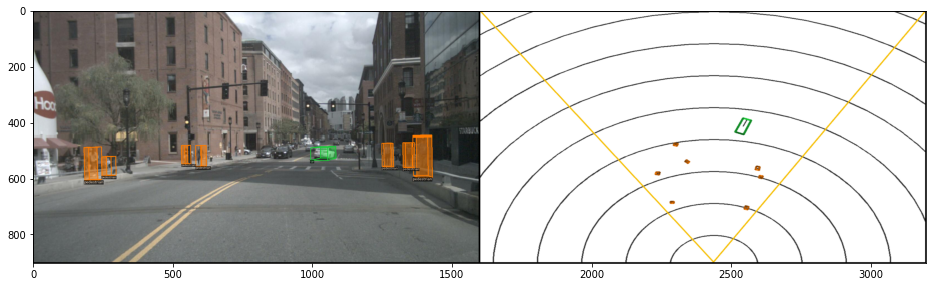

0it [00:04, ?it/s]


In [5]:
dataloader_vis("configs/", "visualize_dataloader", "dd3d_nusc_v99")

Some model parameters or buffers are not found in the checkpoint:
attr_logits.{bias, weight}
speed.{bias, weight}
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/ubuntu/miniconda3/envs/dd3d/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.702 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


intrinsics [809.2209905677063, 0.0, 829.2196003259838, 0.0, 809.2209905677063, 481.77842384512485, 0.0, 0.0, 1.0]
intrinsics <class 'list'>
extrinsics {'wxyz': [0.5037872666382278, -0.49740249788611096, -0.4941850223835201, 0.5045496097725578], 'tvec': [0.0283260309358, 0.00345136761476, 1.57910346144]}


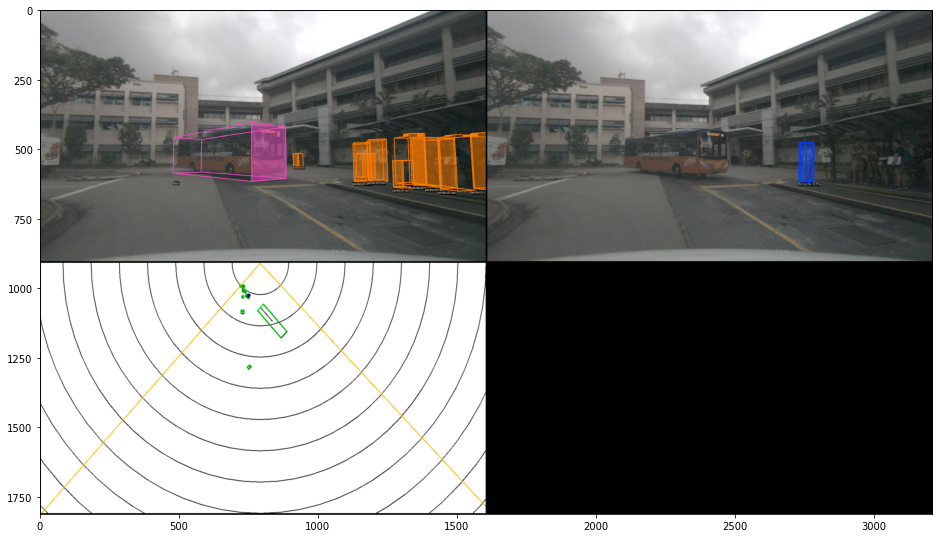

In [6]:
do_test_vis("configs/", "visualize_dataloader", "dd3d_nusc_v99")

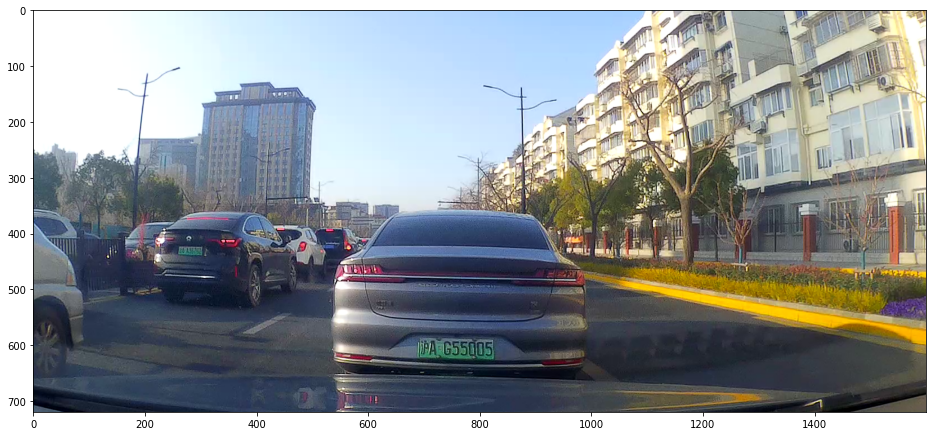

Some model parameters or buffers are not found in the checkpoint:
attr_logits.{bias, weight}
speed.{bias, weight}


scores: tensor([0.8655, 0.7633, 0.6034, 0.2469, 0.2460], device='cuda:0',
       grad_fn=<IndexBackward>)
scores_3d: tensor([0.8037, 0.7060, 0.5368, 0.2068, 0.2038], device='cuda:0',
       grad_fn=<IndexBackward>)


In [24]:
import cv2
import numpy as np
from tridet.structures.pose import Pose
cap = cv2.VideoCapture('2016_0528_130102_538.MP4')
#cap = cv2.VideoCapture('cb38bda4-26729b52.mp4')
def getFrame(cap, sec):
    cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    _, image = cap.read()
    return image

frame = getFrame(cap, 98)
cropped_frame = frame[180:900, 160:1760]
#cropped_frame = frame
fig = plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))
plt.show()

cfg = regen_config("configs/", "visualize_dataloader", "dd3d_nusc_v99")
cfg.DD3D.FCOS2D.INFERENCE.PRE_NMS_THRESH = 0.05
cfg.DD3D.FCOS2D.INFERENCE.NMS_THRESH = 0.3
cfg.DD3D.INFERENCE.DO_BEV_NMS = True
cfg.DD3D.INFERENCE.BEV_NMS_IOU_THRESH = 0.3
#cfg.MODEL.PIXEL_MEAN = [144.49791522, 137.4275897 , 129.99195023]
#cfg.MODEL.PIXEL_STD = [86.4014795 , 85.71474569, 84.38628487]
setup(cfg)
# Build and load model
model = build_model(cfg)
dataset_names = register_datasets(cfg)
checkpoint_file = cfg.MODEL.CKPT
if checkpoint_file:
    Checkpointer(model).load(checkpoint_file)
model.eval()
model.postprocess_in_inference = False

import torchvision.transforms as transforms
from PIL import Image
input_frame = Image.fromarray(cropped_frame)

trans = transforms.Compose([
    transforms.PILToTensor(),
    #transforms.Resize((900, 1600)),
])
input_x = defaultdict(dict)
input_x["image"] = trans(input_frame)
input_x["intrinsics"] = torch.Tensor(
    [
        [1.2473e+03, 0.0000e+00, 8.2297e+02],
        [0.0000e+00, 1.2472e+03, 4.6790e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]
    ]
)
input_x['extrinsics'] = {"wxyz": [0.508, -0.497, 0.498, -0.496], "tvec": [1.72,0.00,1.49]}
extrinsics = input_x['extrinsics']
input_x['pose'] = Pose(wxyz=np.array(extrinsics['wxyz']), tvec=np.array(extrinsics['tvec']))
#input_x['extrinsics'] = {"wxyz": [0.5, -0.5, 0.5, -0.5], "tvec": [1.72,0.00,1.49]}
model.only_box2d = False
result = model([input_x])
pred_instances = result[0]['instances']
pred_boxes3d = pred_instances.pred_boxes3d
pred_class_ids = pred_instances.pred_classes
scores = pred_instances.scores
scores_3d = pred_instances.scores_3d
metadata = MetadataCatalog.get("nusc_mini_val")
print("scores:", scores)
print("scores_3d:", scores_3d)

intrinsics tensor([[1.2473e+03, 0.0000e+00, 8.2297e+02],
        [0.0000e+00, 1.2472e+03, 4.6790e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]])
extrinsics {'wxyz': [0.508, -0.497, 0.498, -0.496], 'tvec': [1.72, 0.0, 1.49]}


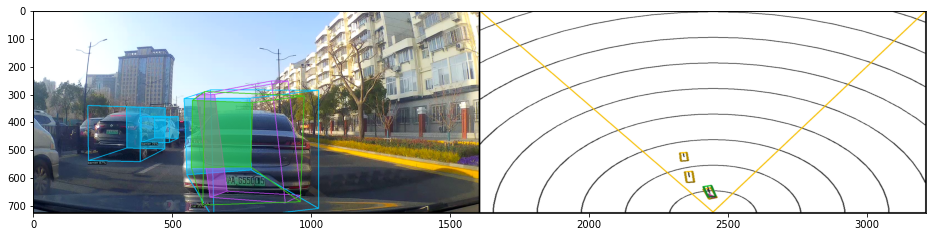

(726, 3212, 3)

In [25]:
from tridet.visualizers.box3d_visualizer import draw_boxes3d_cam, draw_boxes3d_bev, bev_frustum_crop
from tridet.structures.boxes3d import GenericBoxes3D
viz_images = defaultdict(dict)
viz_image = draw_boxes3d_cam(
    cropped_frame.copy(),
    pred_boxes3d,
    pred_class_ids,
    metadata,
    input_x['intrinsics'],
    scores=scores,
    render_labels=True,
)

viz_image = cv2.cvtColor(viz_image, cv2.COLOR_BGR2RGB)
viz_images['viz_pred_boxes3d_cam'] = viz_image

print("intrinsics", input_x['intrinsics'])
print("extrinsics", input_x['extrinsics'])
with torch.no_grad():
    viz_image, _ = draw_boxes3d_bev(
        pred_boxes3d,
        intrinsics=input_x['intrinsics'],
        extrinsics=input_x['extrinsics'],
        class_ids=pred_class_ids,
        image_width=cropped_frame.shape[1],
        metadata=metadata,
        color=(0, 0, 255)
    )

    viz_image = cv2.rotate(viz_image, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
    viz_image = bev_frustum_crop(viz_image)
    viz_images['viz_boxes3d_bev'] = viz_image

fig = plt.figure(figsize=(16,16))
plt_viz = mosaic(list(viz_images.values()))
plt.imshow(cv2.cvtColor(plt_viz[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()
plt_viz[:, :, ::-1].shape

In [3]:
import time
import cv2
import torchvision.transforms as transforms
from tridet.visualizers.box3d_visualizer import draw_boxes3d_cam, draw_boxes3d_bev, bev_frustum_crop
from PIL import Image

def process_cam_dd3d(model, input_file, output_file, intrinsics, extrinsics, frame_num=0):
    totensor_transform = transforms.PILToTensor()
    metadata = MetadataCatalog.get("nusc_mini_val")
    if frame_num == 0:
        out = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'mp4v'), 10, (3212, 726))
    cap = cv2.VideoCapture(input_file)
    frame_idx = 0
    log_frame_num = 120
    start = time.time()
    while(cap.isOpened()):
        capok, frame = cap.read()
        if capok:
            frame_idx += 1
            if frame_idx % 6 != 0:
                continue
            cropped_frame = frame[180:900, 160:1760]
            x = defaultdict(dict)
            viz_images = defaultdict(dict)
            input_frame = Image.fromarray(cropped_frame)
            x["image"] = totensor_transform(input_frame)
            x["intrinsics"] = intrinsics
            x["extrinsics"] = extrinsics
            result = model([x])
            pred_instances = result[0]['instances']
            pred_boxes3d = pred_instances.pred_boxes3d
            pred_class_ids = pred_instances.pred_classes
            scores = pred_instances.scores
            try:
                viz_image = draw_boxes3d_cam(
                    cropped_frame.copy(),
                    pred_boxes3d,
                    pred_class_ids,
                    metadata,
                    x['intrinsics'],
                    scores=scores,
                    render_labels=True,
                )
            except Exception as e:
                print("failed to draw 3D box", e)
                continue
            viz_image = cv2.cvtColor(viz_image, cv2.COLOR_BGR2RGB)
            viz_images['viz_pred_boxes3d_cam'] = viz_image
            with torch.no_grad():
                viz_image, _ = draw_boxes3d_bev(
                    pred_boxes3d,
                    intrinsics=x['intrinsics'],
                    extrinsics=x['extrinsics'],
                    class_ids=pred_class_ids,
                    image_width=cropped_frame.shape[1],
                    metadata=metadata,
                    color=(0, 0, 255)
                )
                viz_image = cv2.rotate(viz_image, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
                viz_image = bev_frustum_crop(viz_image)
                viz_images['viz_boxes3d_bev'] = viz_image
    
            plt_viz = mosaic(list(viz_images.values()))
            if frame_idx > 0 and frame_idx % log_frame_num == 0:
                end = time.time()
                seconds = end - start
                fps  = log_frame_num / seconds
                print("Estimated frames per second : {:.2f}, total frames : {}".format(fps, frame_idx))
                start = time.time()
            if frame_num > 0:
                fig = plt.figure(figsize=(16,16))
                plt.imshow(cv2.cvtColor(plt_viz[:, :, ::-1], cv2.COLOR_BGR2RGB))
                plt.show()
                if frame_idx >= frame_num:
                    break
            else:
                out.write(plt_viz[:, :, ::-1])
        else:
            break
    cap.release()
    if frame_num == 0:
        out.release()

In [4]:
import torch
cfg = regen_config("configs/", "visualize_dataloader", "dd3d_nusc_v99")
cfg.DD3D.FCOS2D.INFERENCE.PRE_NMS_THRESH = 0.05
cfg.DD3D.FCOS2D.INFERENCE.NMS_THRESH = 0.5
cfg.MODEL.PIXEL_MEAN = [144.49791522, 137.4275897 , 129.99195023]
cfg.MODEL.PIXEL_STD = [86.4014795 , 85.71474569, 84.38628487]
setup(cfg)
# Build and load model
model = build_model(cfg)
dataset_names = register_datasets(cfg)
checkpoint_file = cfg.MODEL.CKPT
if checkpoint_file:
    Checkpointer(model).load(checkpoint_file)
model.eval()
model.postprocess_in_inference = False
intrinsics = torch.Tensor(
    [
        [1.2473e+03, 0.0000e+00, 8.2297e+02],
        [0.0000e+00, 1.2472e+03, 4.6790e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]
    ]
)
extrinsics = {"wxyz": [0.508, -0.497, 0.498, -0.496], "tvec": [1.72,0.00,1.49]}

process_cam_dd3d(model, '2016_0528_130102_538.MP4', "2016_0528_130102_538_out.mp4", intrinsics, extrinsics, 0)

/home/ubuntu/miniconda3/envs/dd3d/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'visualize_dataloader': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
Some model parameters or buffers are not found in the checkpoint:
attr_logits.{bias, weight}
speed.{bias, weight}
/home/ubuntu/miniconda3/envs/dd3d/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Estimated frames per second : 9.64, total frames : 120
Estimated frames per second : 10.67, total frames : 240
Estimated frames per second : 8.74, total frames : 360
Estimated frames per second : 7.14, total frames : 480
Estimated frames per second : 6.83, total frames : 600
Estimated frames per second : 6.92, total frames : 720
Estimated frames per second : 6.90, total frames : 840
Estimated frames per second : 6.13, total frames : 960
Estimated frames per second : 6.65, total frames : 1080
Estimated frames per second : 7.09, total frames : 1200
Estimated frames per second : 6.85, total frames : 1320
Estimated frames per second : 7.04, total frames : 1440
Estimated frames per second : 6.10, total frames : 1560
Estimated frames per second : 5.33, total frames : 1680
Estimated frames per second : 5.52, total frames : 1800
Estimated frames per second : 4.62, total frames : 1920
Estimated frames per second : 4.87, total frames : 2040
Estimated frames per second : 5.62, total frames : 2160